### Classificação binária de idade utilizado radiografias panorâmicas da arcada dentária



In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import os
cwd = os.getcwd()

# Shows Current Working Directory
print(cwd)

print(tf.__version__)

C:\Users\geanr\Downloads\PDI_Dental_Age_Classification-main1\PDI_Dental_Age_Classification-main
2.6.0


Dental22  
  22Under/
  22OrOver/

In [2]:
import pathlib
# A pasta valid contém aproximadamente 850 amostras saúdaveis e 850 amostras patológicas, 
#e será usada para  treinamento e validação balanceados
# data_dir = '/content/drive/MyDrive/Colab Notebooks/data/Dental22'
data_dir = cwd + '/data'
data_dir = pathlib.Path(data_dir)
print(data_dir)

C:\Users\geanr\Downloads\PDI_Dental_Age_Classification-main1\PDI_Dental_Age_Classification-main\data


Total de imagens:

In [3]:
image_count = len(list(data_dir.glob('*.jpg')))
print(image_count)

73


Cada diretório contém imagens de pacientes abaixo de 22 anos ou de 22 anos acima.

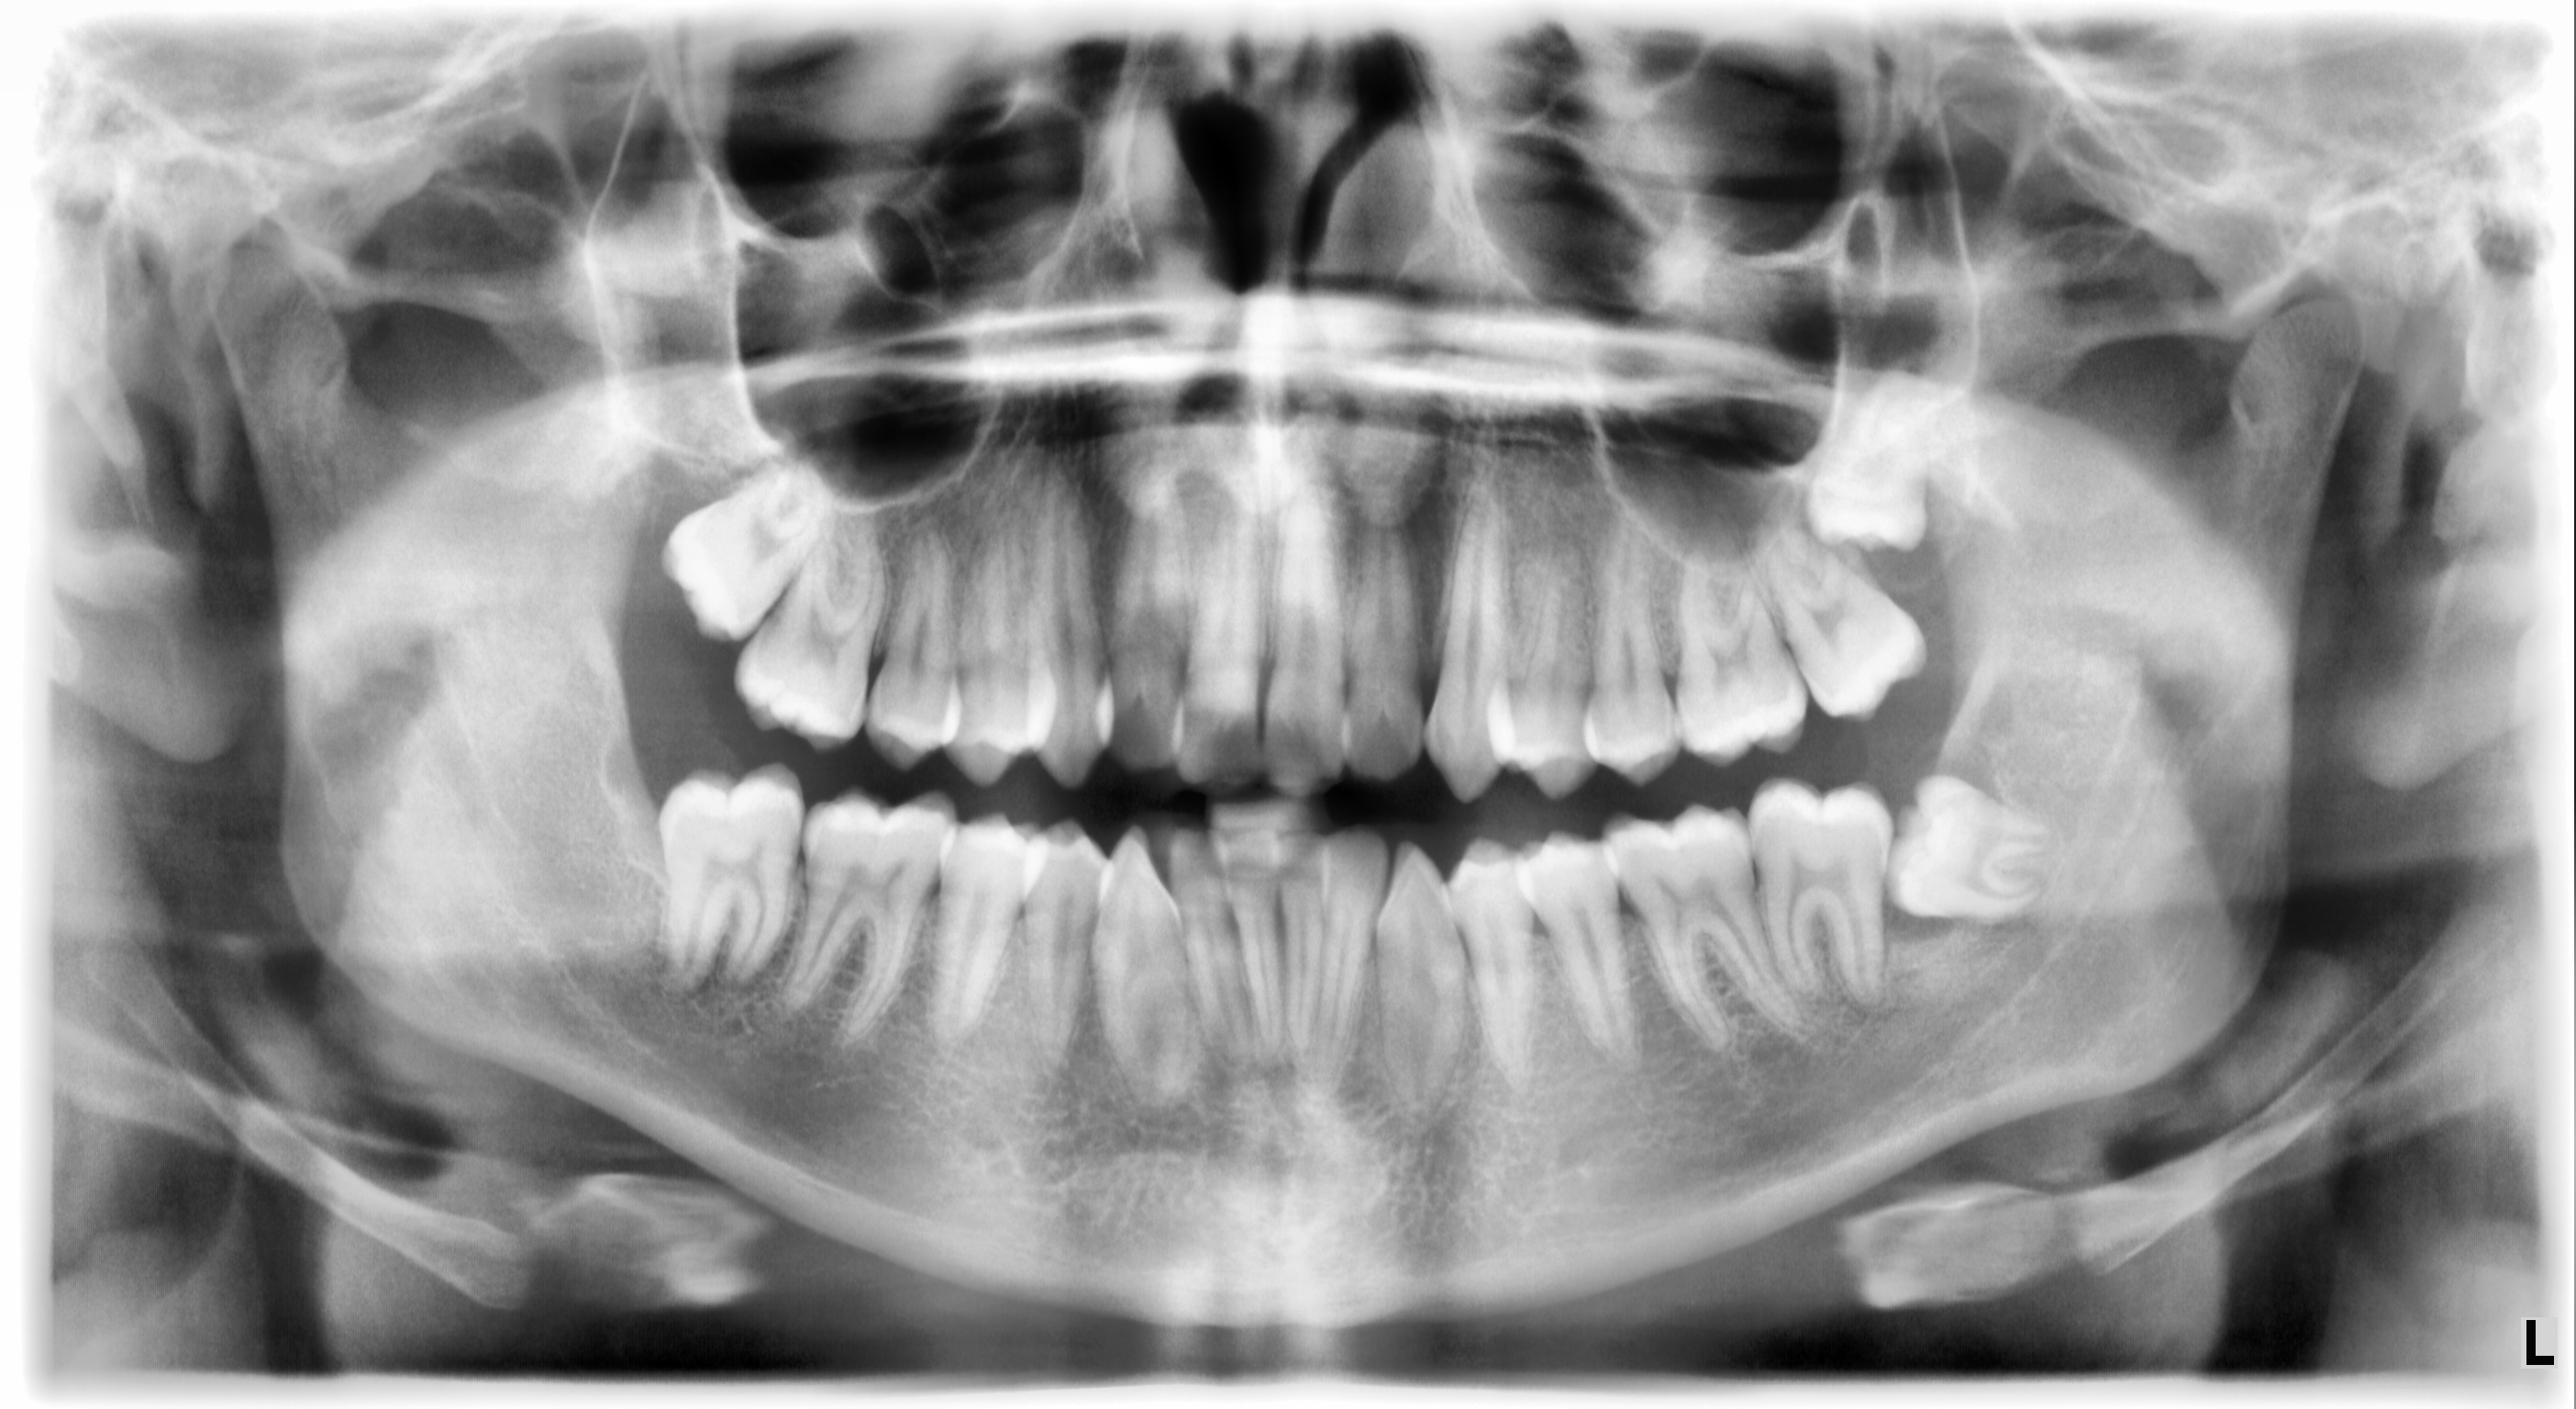

In [4]:
under22 = list(data_dir.glob('22Under/*'))
PIL.Image.open(str(under22[0]))

In [5]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

for f in list_ds.take(5):
  print(f.numpy())

b'C:\\Users\\geanr\\Downloads\\PDI_Dental_Age_Classification-main1\\PDI_Dental_Age_Classification-main\\data\\22OrOver\\20210413154925355.jpg'
b'C:\\Users\\geanr\\Downloads\\PDI_Dental_Age_Classification-main1\\PDI_Dental_Age_Classification-main\\data\\22OrOver\\20210316140819490.jpg'
b'C:\\Users\\geanr\\Downloads\\PDI_Dental_Age_Classification-main1\\PDI_Dental_Age_Classification-main\\data\\22OrOver\\20220216171410578.jpg'
b'C:\\Users\\geanr\\Downloads\\PDI_Dental_Age_Classification-main1\\PDI_Dental_Age_Classification-main\\data\\22Under\\20220111182556416.jpg'
b'C:\\Users\\geanr\\Downloads\\PDI_Dental_Age_Classification-main1\\PDI_Dental_Age_Classification-main\\data\\22OrOver\\20220222134731395.jpg'


A estrutura em árvore dos arquivos pode ser usada para compilar uma lista class_names .

In [6]:
# class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "raw_dataframe_no_name.pkl"]))
class_names = np.array(['22OrOver', '22Under'])
print(class_names)

['22OrOver' '22Under']


Divida o conjunto de dados em conjuntos de treinamento e validação:

In [7]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)


Número de imagens em cada conjunto

In [8]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

60
14


Função que converte um caminho de arquivo em um par (img, label) :

In [9]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

Alguns parâmetros

In [10]:
batch_size = 4
img_height = 224
img_width = 224

Use Dataset.map para criar um conjunto de dados de image, label :

In [11]:
AUTOTUNE = tf.data.AUTOTUNE
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)


In [12]:
for image, label in train_ds.take(5):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  1
Image shape:  (224, 224, 3)
Label:  0
Image shape:  (224, 224, 3)
Label:  1
Image shape:  (224, 224, 3)
Label:  1
Image shape:  (224, 224, 3)
Label:  1


Configurar conjunto de dados para desempenho Para treinar um modelo com esse conjunto de dados, você precisará dos dados:

Para ser bem embaralhado. A ser em lote. Lotes a serem disponibilizados o mais rápido possível. Esses recursos podem ser adicionados usando a API tf.data . Para obter mais detalhes, visite o guia Desempenho do pipeline de entrada .

In [13]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

Visualize os dados

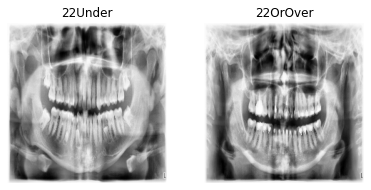

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(2):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Treinando o modelo.

Você construiu manualmente um tf.data.Dataset semelhante ao criado por tf.keras.utils.image_dataset_from_directory acima. Você pode continuar treinando o modelo com ele. Como antes, você treinará por apenas algumas épocas para manter o tempo de execução curto.

Para completar, você mostrará como treinar um modelo simples usando os conjuntos de dados que acabou de preparar.

O modelo Sequencial consiste em três blocos de convolução ( tf.keras.layers.Conv2D ) com uma camada de agrupamento máximo ( tf.keras.layers.MaxPooling2D ) em cada um deles. Há uma camada totalmente conectada ( tf.keras.layers.Dense ) com 128 unidades em cima dela que é ativada por uma função de ativação ReLU ( 'relu' ). Este modelo não foi ajustado de forma alguma - o objetivo é mostrar a mecânica usando os conjuntos de dados que você acabou de criar. Para saber mais sobre classificação de imagens, visite o tutorial Classificação de imagens.

In [18]:
num_classes = 2

#VGG16
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Conv2D(256, 3, activation='relu'),
  tf.keras.layers.Conv2D(256, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Conv2D(512, 3, activation='relu'),
  tf.keras.layers.Conv2D(512, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Conv2D(512, 3, activation='relu'),
  tf.keras.layers.Conv2D(512, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(1)
])

In [19]:
model.compile(
  optimizer='adam',
  loss=tf.losses.BinaryCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [20]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
15/15 [==============================] - 108s 7s/step - loss: 0.7405 - accuracy: 0.5000 - val_loss: 0.6952 - val_accuracy: 0.5714
Epoch 2/5
15/15 [==============================] - 106s 7s/step - loss: 0.6942 - accuracy: 0.5000 - val_loss: 0.6978 - val_accuracy: 0.5714
Epoch 3/5
15/15 [==============================] - 106s 7s/step - loss: 0.6947 - accuracy: 0.5000 - val_loss: 0.6951 - val_accuracy: 0.5714
Epoch 4/5
15/15 [==============================] - 106s 7s/step - loss: 0.6938 - accuracy: 0.5000 - val_loss: 0.6957 - val_accuracy: 0.5714
Epoch 5/5
15/15 [==============================] - 106s 7s/step - loss: 0.6937 - accuracy: 0.5000 - val_loss: 0.6949 - val_accuracy: 0.5714


In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 106, 106, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 128)       0

In [22]:
IMG_SHAPE = (224,224,3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [23]:
base_model.trainable = False
modelMobileNET = Sequential(
    [
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1024, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(1),
    ]
)

In [24]:
base_learning_rate = 0.0001
modelMobileNET.compile(optimizer='Adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
epochs=10

history =  modelMobileNET.fit(
    train_ds,
  validation_data=val_ds,
  epochs=epochs
  )

Epoch 1/10
15/15 [==============================] - 8s 241ms/step - loss: 1.2548 - accuracy: 0.5000 - val_loss: 1.2595 - val_accuracy: 0.4286
Epoch 2/10
15/15 [==============================] - 2s 144ms/step - loss: 0.7892 - accuracy: 0.5833 - val_loss: 1.2501 - val_accuracy: 0.4286
Epoch 3/10
15/15 [==============================] - 2s 146ms/step - loss: 0.8056 - accuracy: 0.5167 - val_loss: 0.6703 - val_accuracy: 0.7143
Epoch 4/10
15/15 [==============================] - 2s 144ms/step - loss: 0.5559 - accuracy: 0.6833 - val_loss: 0.5543 - val_accuracy: 0.8571
Epoch 5/10
15/15 [==============================] - 3s 182ms/step - loss: 0.5046 - accuracy: 0.7167 - val_loss: 0.4890 - val_accuracy: 0.8571
Epoch 6/10
15/15 [==============================] - 2s 144ms/step - loss: 0.4752 - accuracy: 0.7167 - val_loss: 0.4468 - val_accuracy: 0.8571
Epoch 7/10
15/15 [==============================] - 2s 146ms/step - loss: 0.4809 - accuracy: 0.7333 - val_loss: 0.4391 - val_accuracy: 0.6429
Epoch 

In [26]:
class_weight = {0: 1.,
                1: 4.}

Visualize os resultados do treinamento

Crie gráficos de perda e precisão nos conjuntos de treinamento e validação:

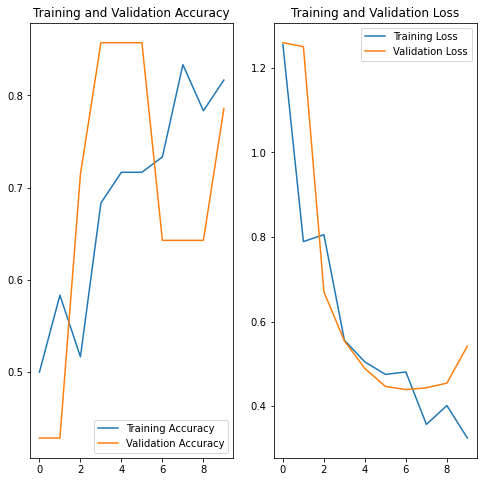

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Os gráficos mostram que a precisão do treinamento e a precisão da validação estão com grandes margens, e o modelo alcançou apenas cerca de 60% de precisão no conjunto de validação.

Vamos inspecionar o que deu errado e tentar aumentar o desempenho geral do modelo.

Aumento de dados
O overfitting geralmente ocorre quando há um pequeno número de exemplos de treinamento. O aumento de dados adota a abordagem de gerar dados de treinamento adicionais de seus exemplos existentes, aumentando-os usando transformações aleatórias que produzem imagens de aparência crível. Isso ajuda a expor o modelo a mais aspectos dos dados e a generalizar melhor.

Você implementará o aumento de dados usando as seguintes camadas de pré-processamento Keras: tf.keras.layers.RandomFlip , tf.keras.layers.RandomRotation e tf.keras.layers.RandomZoom . Eles podem ser incluídos dentro do seu modelo como outras camadas e executados na GPU.

In [32]:
data_augmentation = keras.Sequential(
  [
    tf.keras.layers.RandomCrop(img_height-100,img_width-100),  
    #layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    #layers.RandomRotation(0.1),
    #layers.RandomZoom(0.1),
  ]
)

Vamos visualizar alguns exemplos aumentados aplicando o aumento de dados à mesma imagem várias vezes:

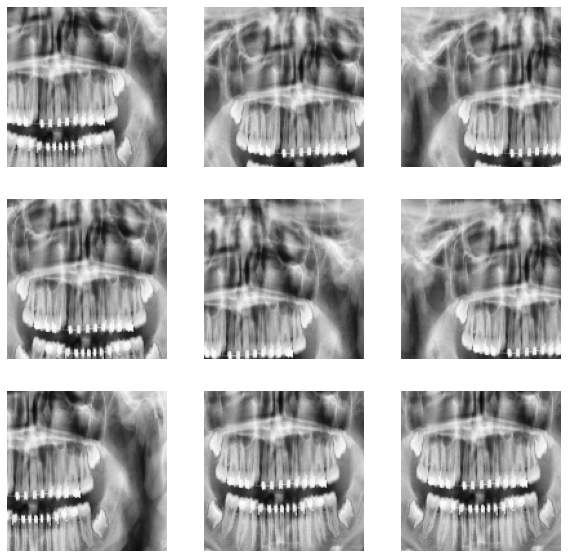

In [33]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Dropout

Outra técnica para reduzir o overfitting é introduzir a regularização de dropout na rede.

Quando você aplica dropout a uma camada, ela descarta aleatoriamente (definindo a ativação como zero) um número de unidades de saída da camada durante o processo de treinamento. Dropout recebe um número fracionário como valor de entrada, na forma de 0,1, 0,2, 0,4, etc. Isso significa descartar 10%, 20% ou 40% das unidades de saída aleatoriamente da camada aplicada.

Vamos criar uma nova rede neural com tf.keras.layers.Dropout antes de treiná-la usando as imagens aumentadas:

In [36]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [40]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [41]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
15/15 [==============================] - 3s 130ms/step - loss: 0.8244 - accuracy: 0.4500 - val_loss: 0.6877 - val_accuracy: 0.5714
Epoch 2/10
15/15 [==============================] - 1s 78ms/step - loss: 0.6959 - accuracy: 0.5000 - val_loss: 0.6961 - val_accuracy: 0.4286
Epoch 3/10
15/15 [==============================] - 1s 77ms/step - loss: 0.6956 - accuracy: 0.4667 - val_loss: 0.6961 - val_accuracy: 0.4286
Epoch 4/10
15/15 [==============================] - 1s 76ms/step - loss: 0.6943 - accuracy: 0.4167 - val_loss: 0.6886 - val_accuracy: 0.5714
Epoch 5/10
15/15 [==============================] - 1s 76ms/step - loss: 0.6895 - accuracy: 0.6000 - val_loss: 0.6794 - val_accuracy: 0.5714
Epoch 6/10
15/15 [==============================] - 1s 77ms/step - loss: 0.6806 - accuracy: 0.6167 - val_loss: 0.6876 - val_accuracy: 0.5714
Epoch 7/10
15/15 [==============================] - 1s 78ms/step - loss: 0.6622 - accuracy: 0.5833 - val_loss: 0.7077 - val_accuracy: 0.5714
Epoch 8/10
1

In [42]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 124, 124, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 124, 124, 3)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 124, 124, 16)      448       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 62, 62, 32)        4640      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 31, 31, 64)       

Visualize os resultados do treinamento
Depois de aplicar o aumento de dados e tf.keras.layers.Dropout , há menos overfitting do que antes, e a precisão do treinamento e da validação está mais alinhada:

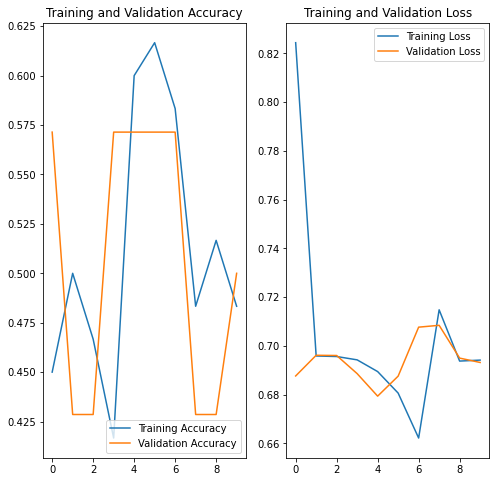

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [47]:
from skimage import io, color

filename = "data/22Under/20210309142219315.jpg"

img = io.imread(filename)
img = color.gray2rgb(img)

Prever novos dados
Por fim, vamos usar nosso modelo para classificar uma imagem que não foi incluída nos conjuntos de treinamento ou validação.

Nota: As camadas de aumento e eliminação de dados estão inativas no momento da inferência.

In [48]:
# img = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
# filename = tf.keras.utils.get_file('Red_sunflower', origin=img)

img = tf.keras.utils.load_img(
    filename, target_size=(img_height, img_width)
)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to 22Under with a 50.16 percent confidence.


Com transfer learning

https://medium.com/analytics-vidhya/face-recognition-using-transfer-learning-and-vgg16-cf4de57b9154

